# GraalVM vs. Standard Java for Cloud Functions

After deploying the GraalVM and Standard Java functions to Cloud Run, get their URLs.

They will look like this:

* GraalVM function: https://my-func-graalvm-2yebdnw3bq-uc.a.run.app
* Standard Java function: https://my-func-java11-2yebdnw3bq-uc.a.run.app

In [1]:
GRAAL_FN = 'my-func-graalvm'
STD_JAVA_FN = 'my-func-java11'

URLS = {
    GRAAL_FN: 'https://my-func-graalvm-2yebdnw3bq-uc.a.run.app',
    STD_JAVA_FN: 'https://my-func-java11-2yebdnw3bq-uc.a.run.app'
}

In [2]:
import random
import requests
import shlex
import subprocess
import time

def run_command(cmd_string):
    output = subprocess.check_output(shlex.split(cmd_string)).strip()
    return output.decode('utf-8')

def redeploy(container_name):
    env_code = random.randint(1, 100000)
    command = 'gcloud run services update %s ' \
        '--update-env-vars FOO=%d --platform managed --region us-central1 --max-instances 1' % (container_name, env_code)
    run_command(command)
    return env_code

def send_request(function_url, coldstart=False):
    if coldstart and '?coldstart' not in function_url:
        function_url += '?coldstart'
    
    start = time.time()
    response = requests.get(function_url, headers = {'Authorization': 'Bearer %s' % TOKEN})
    end = time.time()
    
    
    print(function_url + " | code: " + str(response.status_code))
    if response.status_code == 429:
        time.sleep(30)
    
    if response.status_code == 200:
        return end - start
    else:
        return send_request(function_url, coldstart)

def write_data(number_list, file_name):
    with open(file_name, 'w') as file:
        file.write(",".join(map(lambda num: "%.3f" % float(num), number_list)))
    
TOKEN = run_command('gcloud auth print-identity-token')

## Cold Start Analysis

In this experiment, we measure the cold start time of the containers.

To trigger a cold start on each request, we pass the url parameter `?coldstart` in the URL.
The Java function checks for the prescence of `?coldstart` and will exit the Java process if provided. It is stopped via `System.exit()` which triggers a new instance to be created on the subsequent request:

```
if (httpRequest.getFirstQueryParameter("coldstart").isPresent()) {
      ScheduledExecutorService executorService = Executors.newScheduledThreadPool(1);
      try {
        executorService.schedule(() -> System.exit(0), 1, TimeUnit.SECONDS);
      } catch (Exception e) {
        System.err.println(e);
        System.exit(1);
      }
}
```

Also note, in the Cloud Run settings, `max_instances == 1` to ensure that only one instance is being used for the cold starts experiment.

In [3]:
import os.path

def parseNumbers(filename):
    result = []
    with open(filename, 'r') as file:
        data = file.read().split(",")
        result = list(map(lambda x: float(x), data))
    return result

# Sequential Cold Start Requests
def sequential_cold_start_request(fn_name, times=100):
    print("Sequential cold start tests: " + fn_name)
    results = []
    for i in range(times):
        result = send_request(URLS[fn_name], True)
        results.append(result)
        print("Request %s: time = %.3f" % (fn_name, result))
        time.sleep(5)
    return results

def test_coldstarts(func_name, file_name):
    if os.path.isfile(file_name):
        return parseNumbers(file_name)
    else:
        result = sequential_cold_start_request(func_name)
        write_data(result, file_name)
        return result

std_java_results = test_coldstarts(STD_JAVA_FN, 'std_java_coldstarts.txt')
graalvm_results = test_coldstarts(GRAAL_FN, 'graalvm_coldstarts.txt')

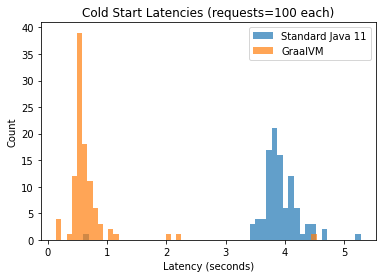

Standard Java Cold Start Latencies Percentiles
Mean = 3.900
Median (50p) = 3.870
95p = 4.439
99p = 4.650

GraalVM Cold Start Latencies Percentiles
Mean = 0.659
Median (50p) = 0.558
95p = 1.075
99p = 2.189



In [4]:
import matplotlib.pyplot as plt
import numpy as np

def printStats(data, title):
    print(title)
    print('Mean = %.3f' % np.mean(data))
    print('Median (50p) = %.3f' % np.percentile(data, 50))
    print('95p = %.3f' % np.percentile(data, 95))
    print('99p = %.3f' % np.percentile(data, 99))
    print()

def plotHistogram(data, title, labels, range=None):
    plt.hist(data, bins=50, histtype='barstacked', label=labels, alpha=0.7, range=range)  # density=False would make counts
    plt.ylabel('Count')
    plt.xlabel('Latency (seconds)');
    plt.title(title)
    plt.legend()
    
plotHistogram([std_java_results], 'Cold Start Latencies', ['Standard Java 11'])
plotHistogram([graalvm_results], 'Cold Start Latencies (requests=100 each)', ['GraalVM'])
plt.show()

printStats(std_java_results, 'Standard Java Cold Start Latencies Percentiles')
printStats(graalvm_results, 'GraalVM Cold Start Latencies Percentiles')


## Sequential Warm Requests Experiment

Send requests sequentially to warmed Cloud Run instance.

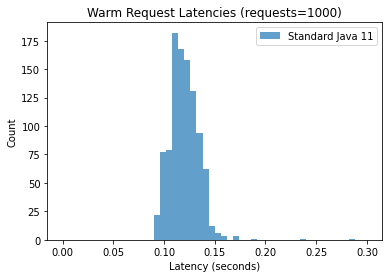

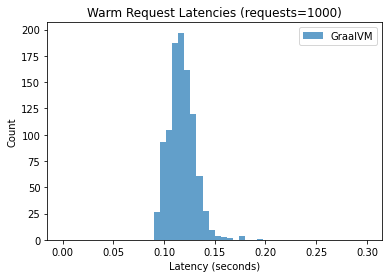

Std. Java Warm Latencies
Mean = 0.120
Median (50p) = 0.118
95p = 0.140
99p = 0.155

GraalVM Warm Latencies
Mean = 0.117
Median (50p) = 0.117
95p = 0.137
99p = 0.154



In [5]:
def sequential_requests(fn_name, times=1000):
    print("Normal Requests: " + fn_name)
    results = []
    for i in range(times):
        result = send_request(URLS[fn_name], False)
        results.append(result)
        print("Request %s: time = %.3f" % (fn_name, result))
    return results

def test_sequential_requests(func_name, file_name):
    if os.path.isfile(file_name):
        return parseNumbers(file_name)
    else:
        result = sequential_requests(func_name)
        write_data(result, file_name)
        return result

std_java_warm = test_sequential_requests(STD_JAVA_FN, 'std_java_warm_requests.txt')
graalvm_warm = test_sequential_requests(GRAAL_FN, 'graalvm_warm_requests.txt')

plotHistogram([std_java_warm], 'Warm Request Latencies (requests=1000)', ['Standard Java 11'], range=(0, 0.3))
plt.show()
plotHistogram([graalvm_warm], 'Warm Request Latencies (requests=1000)', ['GraalVM'], range=(0, 0.3))
plt.show()

printStats(std_java_warm, 'Std. Java Warm Latencies')
printStats(graalvm_warm, 'GraalVM Warm Latencies')


In [6]:
# Busy loop
# for i in range(90000):
#     TOKEN = run_command('gcloud auth print-identity-token')
#     send_request(URLS[GRAAL_FN], False)
#     send_request(URLS[STD_JAVA_FN], False)
#     time.sleep(1)